# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

<img src="https://github.com/oussamarhouch/Projet-Audio/blob/main/figure/model%20based.png?raw=1" alt="CS" style="width: 750px;"/>

## Importing libraries

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import warnings
import random
import logging
torch.cuda.empty_cache()
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Performing preprocessing on the data

##### Unzip the data

In [3]:
# own IDE
# zip_file_paths = ['data/data_part1.zip', 'data/data_part2.zip', 'data/data_part3.zip', 'data/data_part4.zip']

# Google Colab
from google.colab import drive
drive.mount('/content/drive')

os.makedirs("data", exist_ok=True)

zip_file_paths = ['/content/drive/My Drive/audio_project/data_part1.zip',
    '/content/drive/My Drive/audio_project/data_part2.zip',
    '/content/drive/My Drive/audio_project/data_part3.zip',
    '/content/drive/My Drive/audio_project/data_part4.zip']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

##### Data folders

In [5]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

### Clean audio data

##### Load clean audio data

In [32]:
target_duration = 5 # 5sec

In [26]:
# Get the list of clean files
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

In [40]:
clean_data = []
for clean_file in clean_path[:20]:
    s, sr = librosa.load(clean_file, sr=16000)
    target_length = target_duration * sr
    s = librosa.util.fix_length(s, size = target_length)
    clean_data.append(s)

len(clean_data)


20

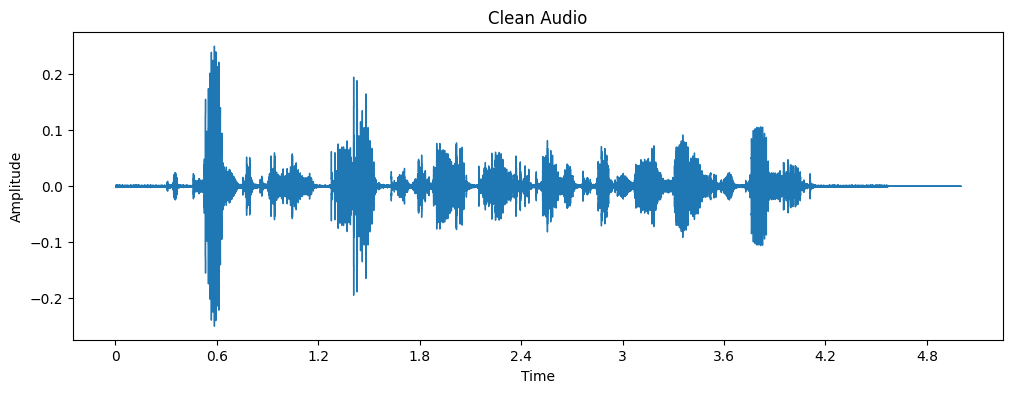

In [41]:
s_rate = 16000

plt.figure(figsize=(12, 4))
librosa.display.waveshow(clean_data[0], sr=s_rate)
plt.title('Clean Audio')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [42]:
write("clean.wav", s_rate, s)

In [43]:
# normalize the clean audio
s_norm = preprocessing.normalize([s])

# Fourier transform
s_stft = librosa.stft(s_norm[0])

# convert to dB
s_stft_db = librosa.amplitude_to_db(abs(s_stft))

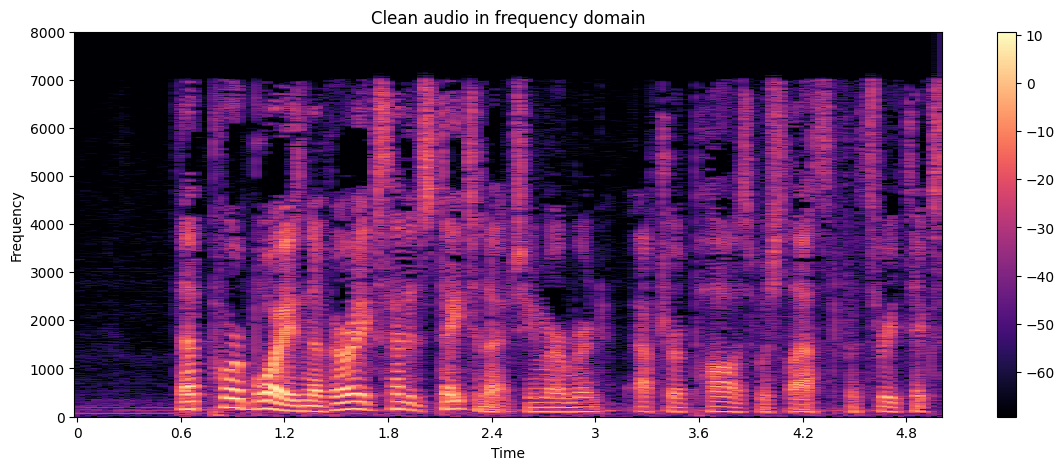

In [44]:
# plot the clean audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(s_stft_db, sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Clean audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [45]:
# Get the list of noise files
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

noise_file

'data/noise/babble_16k.wav'

In [46]:
# load noise data
u, ur = librosa.load(noise_file, sr=16000)

target_length = target_duration * ur
u = librosa.util.fix_length(u, size = target_length)

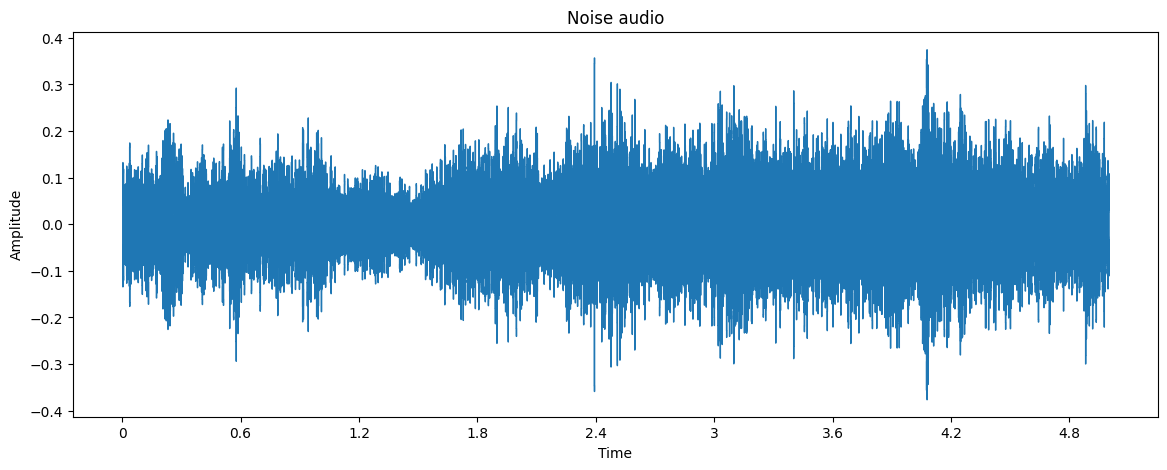

In [48]:
# Plot the noise audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(u, sr=ur)
plt.title("Noise audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [49]:
# normalize the clean audio
u_norm = preprocessing.normalize([u])

# Fourier transform
u_stft = librosa.stft(u_norm[0])

# convert to dB
u_stft_db = librosa.amplitude_to_db(abs(u_stft))

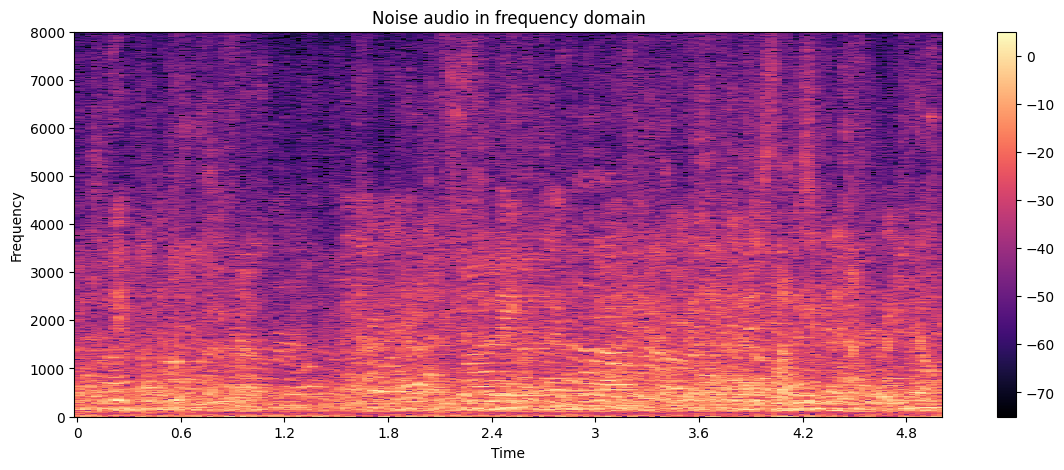

In [50]:
# plot the noise audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(u_stft_db, sr=ur, x_axis="time", y_axis="hz")
plt.title("Noise audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [51]:
# mix the clean and noise audio
rsb = 6
alpha = 10**(-rsb/10)

x = s + alpha * u[:len(s)]
x = x.astype(np.float32)

In [52]:
# save the mixed audio
write(os.path.join('', "mixed.wav"), s_rate, x)

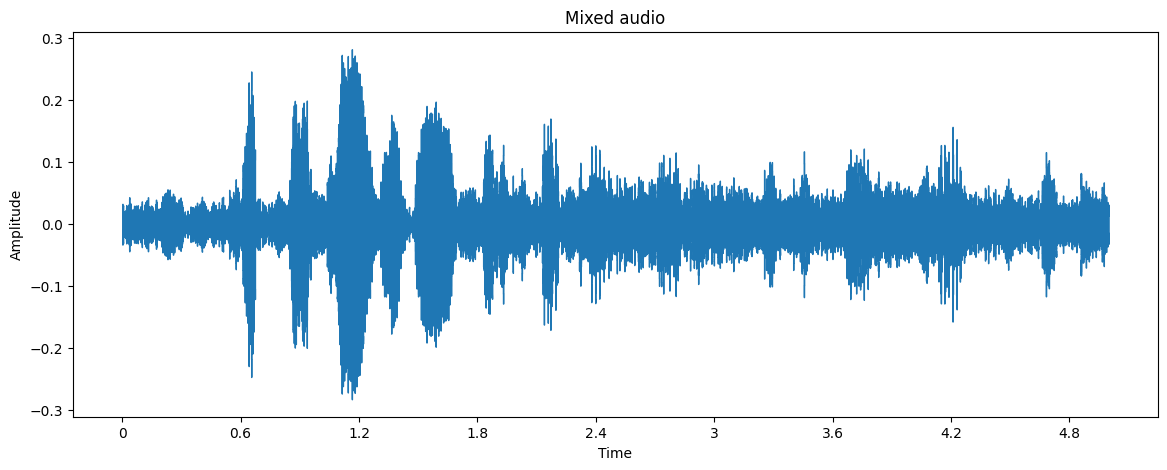

In [53]:
# plot the noisy audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=s_rate)
plt.title("Mixed audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [54]:
# Fourier transform of the noisy audio
x_stft = librosa.stft(x)

# convert to dB
x_stft_db = librosa.amplitude_to_db(abs(x_stft))

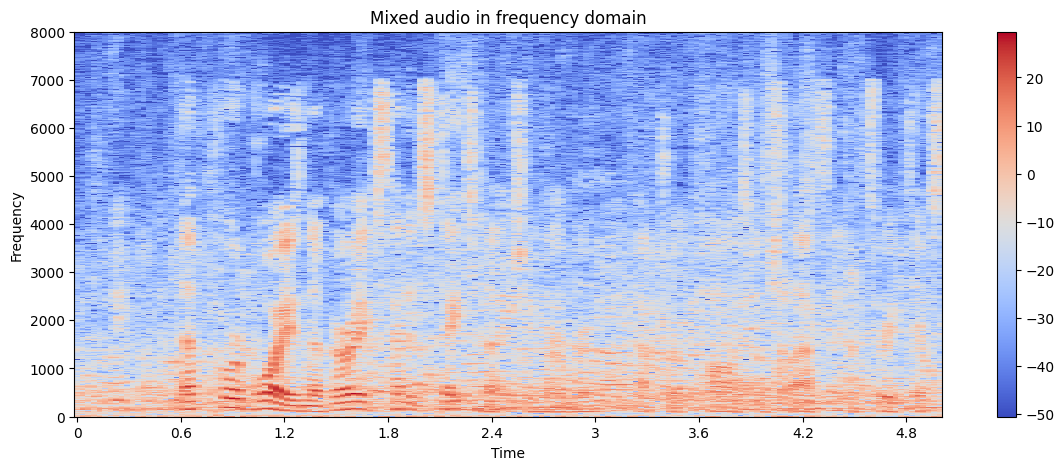

In [56]:
# plot the noisy audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_stft_db, sr=sr, x_axis="time", y_axis="hz")
plt.title("Mixed audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [57]:
s_stft_10s = []
x_stft_10s = []
for i in range(0, len(s_stft)):
    if i % 10 == 0:
        s_stft_10s.append(s_stft[i:i+10])
        x_stft_10s.append(x_stft[i:i+10])

In [58]:
U, _ = librosa.magphase(u_stft)
rms = librosa.feature.rms(S=U)

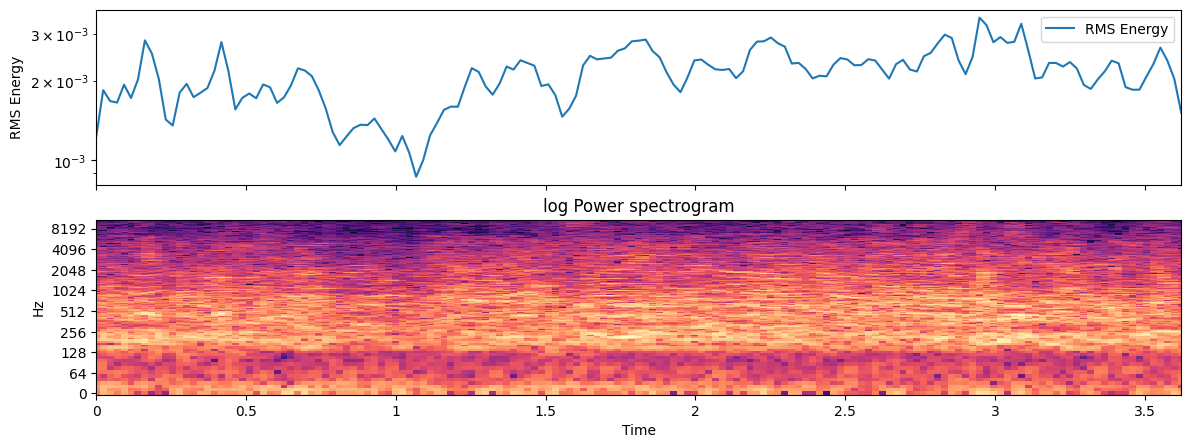

In [59]:
fig, ax = plt.subplots(figsize=(14, 5), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[], xlim=[times.min(), times.max()], ylabel='RMS Energy')
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(U), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

# Preprocessing

In [62]:
class AudioPreprocessor:
    def __init__(self, clean_files, noise_file):
        self.clean_files = clean_files
        self.noise_file = noise_file
        self.clean_data = []
        self.noisy_spec = []
        self.clean_spec = []
        self.original_spec_length = []

    def mix_audio_frequency_domain(self, clean_audio, noise_audio, snr_db):
        # Fourier Transform
        clean_fft = np.fft.fft(clean_audio)
        noise_fft = np.fft.fft(noise_audio[:len(clean_audio)])

        # Calculate the power of the signals in the frequency domain
        clean_power = np.sum(np.abs(clean_fft) ** 2) / len(clean_fft)
        noise_power = np.sum(np.abs(noise_fft) ** 2) / len(noise_fft)

        # Calculate the scaling factor for noise to achieve desired SNR
        alpha = np.sqrt(clean_power / (noise_power * 10 ** (snr_db / 10)))

        # Mix in the frequency domain
        mixed_fft = clean_fft + alpha * noise_fft

        # Inverse Fourier Transform to get back to time domain
        mixed_audio = np.fft.ifft(mixed_fft)
        return np.real(mixed_audio)

    def process_files(self):
        target_duration = 5
        noise_audio, sr_noise = librosa.load(self.noise_file, sr=None)

        for clean_file in self.clean_files:
            clean_audio, sr = librosa.load(clean_file, sr=None)

            target_length = target_duration * sr
            clean_audio = librosa.util.fix_length(clean_audio, size = target_length)

            self.clean_data.append(clean_audio)

        for clean_file in self.clean_data:
            clean_audio = clean_file

            # Resample noise to match the clean file's sample rate if necessary
            if sr != sr_noise:
                noise_audio_resampled = librosa.resample(noise_audio, sr_noise, sr)
            else:
                noise_audio_resampled = noise_audio

            # If noise file is shorter than the clean file, loop it
            if (len(noise_audio_resampled) < len(clean_audio)):
                noise_audio_resampled = librosa.util.fix_length(noise_audio, size = target_duration * sr_noise)

            # Mix with -6 dB SNR in frequency domain
            noisy_audio = self.mix_audio_frequency_domain(clean_audio, noise_audio_resampled, -6)

            # Generate Spectrogram for both noisy and clean audio
            noisy_stft = np.abs(librosa.stft(noisy_audio))
            clean_stft = np.abs(librosa.stft(clean_audio))

            noisy_spectrogram = librosa.amplitude_to_db(noisy_stft, ref=np.max)
            clean_spectrogram = librosa.amplitude_to_db(clean_stft, ref=np.max)

            # Append to respective lists
            self.noisy_spec.append(noisy_spectrogram)
            self.clean_spec.append(clean_spectrogram)
            self.original_spec_length.append(noisy_spectrogram.shape)

In [63]:
preprocessor = AudioPreprocessor(clean_path[:10], noise_file)
preprocessor.process_files()

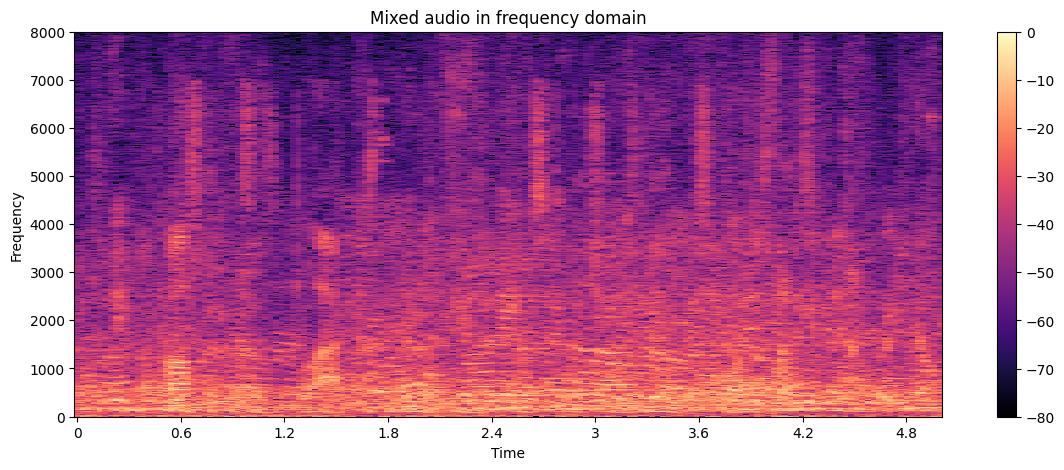

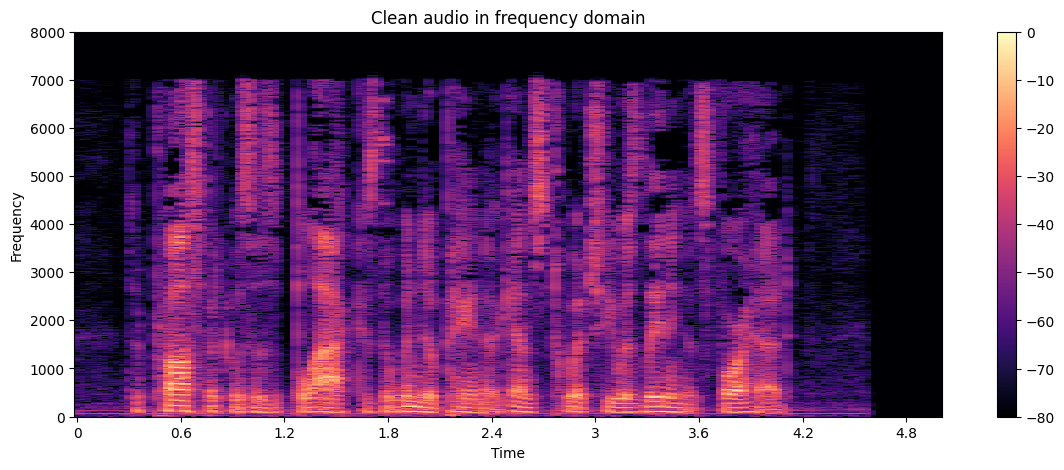

In [65]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(preprocessor.noisy_spec[0], sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Mixed audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

plt.figure(figsize=(14, 5))
librosa.display.specshow(preprocessor.clean_spec[0], sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Clean audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessor.noisy_spec, preprocessor.clean_spec, test_size=0.2, random_state=42
)

In [67]:
class AudioDataset(Dataset):
    def __init__(self, noisy_spectrograms, clean_spectrograms):
        self.noisy_spectrograms = noisy_spectrograms
        self.clean_spectrograms = clean_spectrograms

    def __len__(self):
        return len(self.noisy_spectrograms)

    def __getitem__(self, idx):
        noisy_spec = torch.tensor(self.noisy_spectrograms[idx]).float()
        clean_spec = torch.tensor(self.clean_spectrograms[idx]).float()
        return noisy_spec, clean_spec

In [68]:
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

In [69]:
batch_size = 32

In [70]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Perceptron Model

# CNN Model